# Penyisihan Datavidia 2019
***
**Red Line (Yusnardo Tendio & Helena Angelita Depari) | 27/12/2019**

Pada kernel ini akan dibahas secara detail analisa, praproses, feature engineer, modeling, dan evaluasi (validasi) yang dilakukan.


**Mohon maaf kepada dewan juri dan panitia, tahapan pada modelling, parameter tunning, dan validasi kami comment karena terdapat permasalahan pada saat melakukan commit di kaggle kernel. Setelah kami membaca pada forum tanya jawab kernel, ternyata banyak user yang juga mengalami hal tersebut. Sekali lagi kami mohon maaf**

In [1]:
import numpy
import scipy
import matplotlib
import sklearn
import xgboost
import imblearn

Using TensorFlow backend.


## Daftar Isi
***

* [Import Library Yang Dibutuhkan](#library)
* [1. Pendahuluan](#pendahuluan)
    * [1.1 Deskripsi Dataset](#1.1)
        + [1.1.1 Ukuran dari Masing-masing Dataset](#ukuran_dataset)
        + [1.1.2 Feature pada Dataset](#dataset_feature)
        + [1.1.3 Menampilkan Sebagian Data dari Dataset](#head_tail_dataset)
        + [1.1.4 Menampilkan Nilai Unik Pada Masing-Masing Feature](#unique_value)
        + [1.1.5 Membuat Feature cross_sell](#cross_sell)
    * [1.2 Deskripsi Mengenai Library Yang Digunakan](#1.2)  
        + [1.2.1 Versi dari library yang digunakan](#1.2.1)
        + [1.2.2 Deskripsi singkat dari library yang digunakan](#1.2.2)
* [2. Praproses Data](#praproses)
    * [2.1 Mengatasi Missing Value](#missing_value)
    * [2.2 Mengubah Bentuk visited_city dan log_transaction](#2.2)
    * [2.3 Mengubah Categorical Feature Menjadi Numerik](#2.3)
* [3. EDA](#eda)
    * [3.1 Eksplorasi Feature Kategorikal](#category)
        + [3.1.1 Countplot pada semua feature kategorikal](#3.1.1)
        + [3.1.2 Probabilitas terjadi cross selling berdasarkan feature yang ada](#3.1.2)
        + [3.1.3 Factorplot antar feature](#3.1.3)
        + [3.1.4 Feature route](#3.1.4)
    * [3.2 Eksplorasi Feature Numerik](#numeric)
        + [3.2.1 Distribusi antar feature](#3.2.1)
        + [3.2.2 Scatterplot antar feature](#3.2.2)
    * [3.3 Kesimpulan Hasil Eksplorasi](#3.3)
* [4. Feature Engineering](#4)
    * [4.1 Membuat Feature Baru](#4.1)
        + [4.1.1 Feature baru dari member_duration_days](#4.1.1)
        + [4.1.2 Feature baru dari price](#4.1.2)
        + [4.1.3 Feature baru dari no_of_seats](#4.1.3)
        + [4.1.4 Feature baru dari account_id dan cross_sell](#4.1.4)
    * [4.2 Menghapus Feature Yang Tidak Berguna](#4.2)
    * [4.3 Mengubah Variabel Kategorikal Menjadi Dummy](#4.3)
* [5. Modelling dan Validasi](#5)
    * [5.1 Sampling, Normalisasi dan Split Data](#5.1)
    * [5.2 Modeling dan Validasi Dengan Berbagai Metode](#5.2)
    * [5.3 Parameter Tunning](#5.3)
        + [5.3.1 Parameter tuning pada XGBoost](5.3.1)
        + [5.3.2 Parameter tuning pada k-NN](5.3.2)
        + [5.3.3 Parameter tuning pada Random Forest](5.3.3)
        + [5.3.4 Parameter tuning pada Decision Tree](5.3.4)
        + [5.3.5 Parameter tuning pada Gradient Boosting](5.3.5)
        + [5.3.6 Modelling & Validasi menggunakan parameter optimal](5.3.6)
    * [5.4 Voting Classifier](#5.4)
* [References](#ref)

# Import Library Yang Dibutuhkan
<a id="library"></a>
***
Pada tahap ini, library-library yang dibutuhkan dalam pengerjaan diimport. Selain itu, kami juga memasukan data yang dibutuhkan untuk analisa dan pelatihan.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rnd
from scipy import stats
import copy 
import warnings
warnings.filterwarnings('ignore')

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine-learning
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.feature_selection import RFE, RFECV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import BaggingClassifier

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
flight = pd.read_csv('../input/datavidia2019/flight.csv')
df_test = pd.read_csv('../input/datavidia2019/test.csv')
hotel = pd.read_csv('../input/datavidia2019/hotel.csv')

/kaggle/input/datavidia2019/flight.csv
/kaggle/input/datavidia2019/sample_submission.csv
/kaggle/input/datavidia2019/Data Dictionary.pdf
/kaggle/input/datavidia2019/hotel.csv
/kaggle/input/datavidia2019/test.csv


# 1. Pendahuluan
<a id="pendahuluan"></a>
***
Dataset yang diberikan kepada peserta terdiri atas dataset 'flight' yang mana merupakan sample dari order tiket pesawat, dataset 'hotel' yang mana berisi tentang data hotel yang berhubungan dengan pembelian melalui platform Tiket.com, sedangkan dataset 'test' berisi data yang harus diprediksi apakah terjadi cross_sell atau tidak. Adapun pengertian cross_sell dalam studi kasus ini adalah kondisi dimana pelanggan memesan hotel bersamaan dengan transaksi pembelian tiket.

Pada kondisi ini, sesungguhnya dataset 'hotel' tidak dapat memberikan dampak apapun terhadap model untuk memprediksi cross_sell karena prediksi cross_sell dilakukan untuk memprediksi apakah pelanggan juga memesan hotel saat memesan tiket pesawat. Berikut adalah deskripsi dari dataset secara singkat

## 1.1 Deskripsi Dataset
<a id="1.1"></a>
***

### 1.1.1 Ukuran Dataset
<a id="ukuran_dataset"></a>
***
Diketahui bahwa pada dataset 'flight' terdapat 14 feature dan 117.946 baris data, sedangkat setiap kelompok harus memprediksi 10.000 baris data yang tardapat pada dataset 'test'

In [3]:
# Melihat ukuran dari data
print('Ukuran data flight adalah', flight.shape)
print('Ukuran data test adalah', df_test.shape)

Ukuran data flight adalah (117946, 14)
Ukuran data test adalah (10000, 13)


### 1.1.2 Feature pada Dataset
<a id="dataset_feature"></a>
***
Feature yang terdapat pada dataset 'flight' dan 'test' kurang lebih sama, dimana terdapat 3 numerical feature dan 11 categorical feature.****

In [4]:
print('Pada dataset flight terdapat beberapa feature, yaitu: ')
print('\n')
num_features = flight.select_dtypes(['float64', 'int64']).columns.tolist()
cat_features = flight.select_dtypes(['object']).columns.tolist()
print('{} numerical features:\n{} \n{} categorical features:\n{}'.format(len(num_features), num_features, len(cat_features), cat_features))
print('\n')
print('\n')
print('Sedangkan, pada dataset test terdapat beberapa feature, yaitu: ')
print('\n')
num_features = df_test.select_dtypes(['float64', 'int64']).columns.tolist()
cat_features = df_test.select_dtypes(['object']).columns.tolist()
print('{} numerical features:\n{} \n{} categorical features:\n{}'.format(len(num_features), num_features, len(cat_features), cat_features))

Pada dataset flight terdapat beberapa feature, yaitu: 


3 numerical features:
['member_duration_days', 'price', 'no_of_seats'] 
11 categorical features:
['account_id', 'order_id', 'gender', 'trip', 'service_class', 'is_tx_promo', 'airlines_name', 'route', 'hotel_id', 'visited_city', 'log_transaction']




Sedangkan, pada dataset test terdapat beberapa feature, yaitu: 


3 numerical features:
['member_duration_days', 'price', 'no_of_seats'] 
10 categorical features:
['account_id', 'order_id', 'gender', 'trip', 'service_class', 'is_tx_promo', 'airlines_name', 'route', 'visited_city', 'log_transaction']


### 1.1.3 Menampilkan Sebagian Data dari Dataset
<a id="head_tail_dataset"></a>
***


In [5]:
flight.head()

,account_id,order_id,member_duration_days,gender,trip,service_class,price,is_tx_promo,no_of_seats,airlines_name,route,hotel_id,visited_city,log_transaction
0,912aa410a02cd7e1bab414214a7005c0,5c6f39c690f23650d3cde28e5b51c908,566.0,M,trip,ECONOMY,885898.00,NO,1.0,33199710eb822fbcfd0dc793f4788d30,CGK - DPS,None,"'['Semarang', 'Jakarta', 'Medan', 'Bali']'","'[545203.03, 918492.11, 1774241.4, 885898.0]'"
1,d64a90a618202a5e8b25d8539377f3ca,5cbef2b87f51c18bf399d11bfe495a46,607.0,M,trip,ECONOMY,2139751.25,NO,2.0,0a102015e48c1f68e121acc99fca9a05,CGK - DPS,None,"'['Jakarta', 'Medan', 'Bali']'","'[555476.36, 2422826.84, 7398697.64, 7930866.8..."
2,1a42ac02bcb4a902973123323f84da55,38fc35a1e62384012a358ab1fbd5ad03,648.0,F,trip,ECONOMY,2695550.00,NO,1.0,0a102015e48c1f68e121acc99fca9a05,CGK - DPS,None,"'['Semarang', 'Jakarta', 'Medan', 'Bali']'","'[7328957.45, 7027662.34, 1933360.88, 3461836...."
3,92cddd64d4be4dec6dfbcc0c50e902f4,c7f54cb748828b4413e02dea2758faf6,418.0,F,trip,ECONOMY,1146665.00,NO,1.0,0a102015e48c1f68e121acc99fca9a05,CGK - DPS,None,"'['Jogjakarta', 'Bali', 'Jakarta', 'Medan']'","'[5243631.69, 2474344.48, 1146665.0]'"
4,bf637abc47ea93bad22264f4956d67f6,dec228e4d2b6023c9f1fe9cfe9c451bf,537.0,F,trip,ECONOMY,1131032.50,NO,1.0,6c483c0812c96f8ec43bb0ff76eaf716,CGK - DPS,None,"'['Jakarta', 'Bali', 'Medan', 'Jogjakarta', 'S...","'[9808972.98, 9628619.79, 6712680.0, 5034510.0..."


In [6]:
flight.tail()

,account_id,order_id,member_duration_days,gender,trip,service_class,price,is_tx_promo,no_of_seats,airlines_name,route,hotel_id,visited_city,log_transaction
117941,df5f430ac83802353fc31a1fb3f2ae01,8fd1991a2ed79d23b820c6f9c0198c9f,518.0,M,trip,ECONOMY,2262328.64,NO,2.0,6c483c0812c96f8ec43bb0ff76eaf716,CGK - DPS,None,"'['Bali', 'Jakarta', 'Medan']'","'[7811040.61, 2262328.64]'"
117942,3803020866c08728c0e9cc5ae2ab174c,e91239e71d510c1e367133233b15ffdf,377.0,M,round,ECONOMY,966680.00,NO,1.0,33199710eb822fbcfd0dc793f4788d30,CGK - DPS,None,"'['Bali', 'Jakarta', 'Medan']'","'[8937712.37, 7654095.51, 966680.0]'"
117943,7f71c64acc57b0d3b92ce4533a7c52ee,941b0d0d3ee13e528a7f59934b199844,1034.0,F,trip,ECONOMY,1084980.00,NO,1.0,33199710eb822fbcfd0dc793f4788d30,CGK - DPS,None,"'['Medan', 'Bali', 'Jakarta']'","'[9889984.19, 2728775.6, 6821124.99, 5251383.2..."
117944,a246dccf61c80100f1df03e9b85d4665,d122b9d10ae0c4f013ba779172e3931b,1291.0,F,trip,ECONOMY,4915872.00,NO,3.0,33199710eb822fbcfd0dc793f4788d30,CGK - DPS,None,"'['Semarang', 'Jakarta', 'Medan', 'Bali']'","'[3237619.11, 8213313.08, 4915872.0]'"
117945,3d94f293bdb0afad2b68950c125a561f,0f568900ff006e53506b2a4ade68e8e2,1591.0,F,trip,ECONOMY,5029440.00,NO,4.0,6c483c0812c96f8ec43bb0ff76eaf716,CGK - DPS,None,"'['Jakarta', 'Medan', 'Bali']'","'[2481129.22, 354100.52, 7089785.17, 1854491.5..."


In [7]:
flight.describe()

,member_duration_days,price,no_of_seats
count,117946.000000,1.179460e+05,117946.000000
mean,955.586955,2.672772e+06,1.688595
std,565.292428,2.449247e+06,1.133721
min,329.000000,4.069520e+05,1.000000
25%,537.000000,1.282710e+06,1.000000
50%,678.000000,1.987061e+06,1.000000
75%,1341.000000,2.974400e+06,2.000000
max,2720.000000,5.903643e+07,11.000000


In [8]:
df_test.describe()

,member_duration_days,price,no_of_seats
count,10000.000000,1.000000e+04,10000.000000
mean,960.088100,2.682194e+06,1.692800
std,567.917055,2.398099e+06,1.111374
min,329.000000,3.205930e+05,1.000000
25%,535.000000,1.304849e+06,1.000000
50%,682.000000,2.019924e+06,1.000000
75%,1348.000000,2.988765e+06,2.000000
max,2710.000000,3.855515e+07,10.000000


### 1.1.4 Menampilkan Nilai Unik Pada Masing-Masing Feature
<a id="unique_value"></a>
***
Terdapat hal menarik yang didapatkan pada tahap ini, yaitu
1. Pada feature 'account_id' hanya terdapat 74.796 akun unik, sehingga terdapat akun yang melakukan pembelian berkali-kali pada platform Tiket.com di tahun 2018. Hal ini juga dapat dimanfaatkan untuk meningkatkan score model yang dihasilkan.
2. Data yang dimiliki tidak terdapat nilai yang duplikat, hal ini dibuktikan dengan jumlah nilai unik pada feature order_id
3. Terdapat 24 missing value pada feature gender
4. Data service_class business sangatlah sedikit, sehingga kemungkinan tidak akan membantu dalam pembuatan model prediksi yang akurat.
5. Feature route hanya terdapat 1 value yaitu CGK - DPS sehingga tidak berguna dalam pembuatan model prediksi.
6. Tidak terdapat missing value pada data test

In [9]:
for col in flight.columns:
    print('Nilai unik pada feature', col, 'adalah')
    print(flight[col].value_counts())
    print('\n')

Nilai unik pada feature account_id adalah
d64a90a618202a5e8b25d8539377f3ca    3311
fbb4123bb341ad85719af86930a0ccea     311
bf637abc47ea93bad22264f4956d67f6     161
74b423f5354172076e9529debf8866ac     145
4944140d10e202e845f0766a3e3ac2d1     133
                                    ... 
ae6d1cf65ee295ed83f4bb9758a008c1       1
54df8ca2fca2bed65f91473410248a03       1
898cea82734f77f823f8d65b11aa7ef9       1
3e00ea5968fa4c0be8a994d6386e37c6       1
b71fd002db3680ad28a416d8592bf848       1
Name: account_id, Length: 74796, dtype: int64


Nilai unik pada feature order_id adalah
83706690f7413d10de362ddfd8aae253    1
94e97b970d034e574a0a1a825d1f8f54    1
eadc10835f9b43123dbfa720249cb478    1
dc8f0a823b19b65c5e9642dd7aff3b3c    1
3c97746b4b9b8f13adf904d6ccbd54a4    1
                                   ..
389ff69ef2ca00c8207181da83d31025    1
586e8b8968543276a072bcd6a2a5581d    1
5d7103d62d7cf01e9317445db53a257d    1
0713a5c329dc938da8741c0a15fa4ad3    1
fa4832ac2643f480f33f74a207b45fb1    1
N

In [10]:
for col in df_test.columns:
    print('Nilai unik pada feature', col, 'adalah')
    print(df_test[col].value_counts())
    print('\n')

Nilai unik pada feature account_id adalah
d64a90a618202a5e8b25d8539377f3ca    209
f7b64bbf8462b0d1a006af1a983c609d     26
fbb4123bb341ad85719af86930a0ccea     19
5634d6fd8d25ce0fd43b00a26d6dc17c     19
49aef087188299dca09278b382147b44     19
                                   ... 
5610de18970f53c3f014f117edd04872      1
9a4e6afba1bace6aa746795a524becc6      1
5ba6896758cd686be30f38e5409339f1      1
a92a8f8b84139d5f2e1af72ed2de1fe4      1
1685e0f2cb7602bb3d8214a7eaead39a      1
Name: account_id, Length: 8724, dtype: int64


Nilai unik pada feature order_id adalah
53fc486f55d9c3eb6821b23e3bd8c01a    1
4cc8f69db6d2ece8a4e41c968b458385    1
43ab4e216b8df83f8d06f481d98902c5    1
dd60ae1b8e81f4da4ed7db533cd73568    1
752092485e318fa728eb62ccb72e9ec4    1
                                   ..
bb2a1e8b68d34a29693846b88bbb4790    1
dd8d935ecb3889cc2481ac341aa95cc9    1
db52a1b523812639766ccbe059d43417    1
f3f68495b3334f21b94455cd4e8c930f    1
7c871d4049d0743504a0da4e5e83ff01    1
Name: order_i

### 1.1.5 Membuat Feature cross_sell
<a id="cross_sell"></a>
***
Pada tahapan ini, tim Red Line akan mengekstrak feature hotel_id menjadi feature cross_sell sehingga mudah dalam menjalankan tahapan-tahapan selanjutnya. Adapun feature hotel_id akan langsung dihapus pada tahapan ini.

In [11]:
# Membuat feature cross_sell berdasarkan ada atau tidak adanya hotel id
var_target = []
for i in range(0, len(flight.hotel_id)):
    val = flight.hotel_id[i]
    if val != 'None':
        var_target.append(1)
    else:
        var_target.append(0)

flight['cross_sell'] = pd.Series(np.array(var_target))
flight.drop(['hotel_id'], axis=1, inplace = True)

## 1.2 Deskripsi Mengenai Library Yang Digunakan
<a id="1.2"></a>
***

### 1.2.1 Versi library yang digunakan
<a id="1.2.1"></a>
***
Berikut adalah versi dari library-library yang digunakan.

In [12]:
used_library = [
    numpy, pd, scipy, sns, matplotlib, sklearn, xgboost, imblearn
]
print('Library yang digunakan pada kernel ini adalah sebagai berikut.\n')
for library in used_library:
    print('Library', library.__name__, 'dengan versi', library.__version__)

Library yang digunakan pada kernel ini adalah sebagai berikut.

Library numpy dengan versi 1.17.4
Library pandas dengan versi 0.25.3
Library scipy dengan versi 1.3.3
Library seaborn dengan versi 0.9.0
Library matplotlib dengan versi 3.0.3
Library sklearn dengan versi 0.21.3
Library xgboost dengan versi 0.90
Library imblearn dengan versi 0.5.0


### 1.2.2 Deskripsi singkat dari library yang digunakan
<a id="1.2.2"></a>
***

+ **Numpy** <br>
Digunakan untuk operasi vektor dan matriks. Pada kernel ini, Numpy digunakan hampir pada semua tahapan.
+ **Pandas** <br>
Digunakan untuk import/export dataset, membangun DataFrame/Series, dll
+ **Scipy** <br>
Digunakan untuk menangani operasi matematika terutama statistika.
+ **Seaborn** <br>
Digunakan untuk membuat plot pada eksplorasi dan analisa data.
+ **Matplotlib** <br>
Digunakan untuk membuat plot pada eksplorasi dan analisa data.
+ **Sklearn** <br>
Digunakan untuk membuat model Decision Tree, Gradient Booster, k-NN, Random Forest, Voting Classifier. Juga digunakan untuk mempartisi dan menormalisasi data.
+ **XGBoost** <br>
Digunakan untuk membuat model Extreme Gradient Boosting.
+ **Imblearn** <br>
Digunakan untuk melakukan sampling data (mengatasi class yang unbalanced), dalam hal ini menggunakan metode SMOTE pada library tersebut.

# 2. Praproses Data
<a id="praproses"></a>
***
Pada tahap ini, kelompok Red Line membersihkan dan mempersiapkan data yang masih mentah untuk dapat dimanfaatkan dalam pembangunan model prediksi. Tahapan-tahapan yang akan dilakukan dalam hal ini adalah mengatasi data yang hilang, mengatasi outlier dan lain-lain.

## 2.1 Mengatasi Missing Value
<a id="missing_value"></a>
***
Pada sub-bab 1.1.4, tim Red Line telah mengidentifikasi bahwa terdapat missing value pada feature gender dan tidak terdapat missing value pada feature lainnya. C

ode dibawah ini digunakan untuk menghapus data yang missing value apabila tidak terjadi cross_selling dan jika data yang mengandung missing value terjadi cross_selling maka akan dilakukan pengisian berdasarkan modus dari gender yang terjadi cross_selling, dalam hal ini Male. Metode mengatasi missing value ini dilakukan karena dataset yang dimiliki memiliki jumlah class yang tidak seimbang (berdasarkan hipotesis awal bahwa pembelian tiket pesawat sekaligus dengan pemesanan hotel akan jauh lebih sedikit jumlahnya dibandingkan dengan pembelian tiket pesawat saja maupun hotel saja). Hipotesis tersebut akan dibuktikan pada sub-bab 3.1.1.

In [13]:
# Code untuk mengecek baris data mana yang terdapat missing value pada variabel gender
missing_index = []
for i in range(0, len(flight.gender)):
    val = flight.gender[i]
    if val != 'M' and val != 'F':
        missing_index.append(i)
        #print(i)
    else:
        continue

missing_index_no_cs = []
missing_index_with_cs = []
for i in missing_index:
    if flight.iloc[i].cross_sell == 0:
        missing_index_no_cs.append(i)
        print('data flight index {} yang terdapat missing value tidak terjadi cross selling'.format(i))
    else:
        missing_index_with_cs.append(i)
        print('data flight index {} yang terdapat missing value terjadi cross selling'.format(i))


# Menghapus data yang missing value pada gender dan tidak terjadi cross selling
flight = flight.drop(missing_index_no_cs, axis = 0)
flight.reset_index(drop=True, inplace=True)

# Memasukan nilai modus pada missing value gender yang terjadi cross selling. 
# Dilakukan secara manual karena hanya terdapat 2 baris yang memiliki kondisi tersebut.
flight.gender[65919, 106169] = 'M'

data flight index 8744 yang terdapat missing value tidak terjadi cross selling
data flight index 20057 yang terdapat missing value tidak terjadi cross selling
data flight index 21913 yang terdapat missing value tidak terjadi cross selling
data flight index 23984 yang terdapat missing value tidak terjadi cross selling
data flight index 38546 yang terdapat missing value tidak terjadi cross selling
data flight index 47449 yang terdapat missing value tidak terjadi cross selling
data flight index 49846 yang terdapat missing value tidak terjadi cross selling
data flight index 52547 yang terdapat missing value tidak terjadi cross selling
data flight index 52904 yang terdapat missing value tidak terjadi cross selling
data flight index 55234 yang terdapat missing value tidak terjadi cross selling
data flight index 55786 yang terdapat missing value tidak terjadi cross selling
data flight index 65930 yang terdapat missing value terjadi cross selling
data flight index 67910 yang terdapat missing v

## 2.2 Mengubah Bentuk visited_city dan log_transaction
<a id="2.2"></a>
***
Pada tahap ini, dilakukan perubahan bentuk dari visited_city dan log_transaction yang awalnya merupakan string. Tahap ini dilakukan agar kedua feature tersebut menjadi lebih bermanfaat. Code dibawah ini juga terdapat beberapa feature engineering, yang dianggap perlu untuk dimasukan pada sub-bab ini.

In [14]:
def ubah_visited_city(dataset):
    """ Docstring
    Fungsi ini digunakan untuk mengubah feature visited_city menjadi bentuk yang lebih berguna.
    Pada fungsi ini juga dilakukan pembuatan array yang mengembalikan nilai apakah pelanggan pernah
    berkunjung di Semarang, Jogja, Surabaya, Aceh, atau Manado.
    
    Fungsi ini hanya berguna pada dataset yang digunakan dalam penyisihan Datavidia 2019, menerima 
    input parameter dataset dalam hal ini flight dan dataset test.
    """
    visit_semarang = []
    visit_jogja = []
    visit_sby = []
    visit_aceh = []
    visit_manado = []
    for i in range(0, len(dataset.visited_city)):
        val = dataset.visited_city[i]
        val = val.replace('[', '').replace(']', '').replace("'", '').split(',')
        if 'Semarang' in val:
            visit_semarang.append(1)
        else:
            visit_semarang.append(0)
        if 'Jogjakarta' in val:
            visit_jogja.append(1)
        else:
            visit_jogja.append(0)
        if 'Surabaya' in val:
            visit_sby.append(1)
        else:
            visit_sby.append(0)
        if 'Aceh' in val:
            visit_aceh.append(1)
        else:
            visit_aceh.append(0)
        if 'Manado' in val:
            visit_manado.append(1)
        else:
            visit_manado.append(0)
    return visit_semarang, visit_jogja, visit_sby, visit_aceh, visit_manado

def ubah_log_transaction(dataset):
    """ Docstring
    Fungsi ini digunakan untuk mengubah feature log_transaction menjadi bentuk yang lebih berguna.
    Pada fungsi ini juga dilakukan pembuatan array yang mengembalikan nilai jumlah, total, dan rata-rata
    transaksi. Selain itu, fungsi ini juga mengembalikan nilai binary apakah pelanggan telah 
    bertransaksi lebih dari 10 juta, 50 juta, atau bahkan 100 juta.
    
    Fungsi ini hanya berguna pada dataset yang digunakan dalam penyisihan Datavidia 2019, menerima 
    input parameter dataset dalam hal ini flight dan dataset test.
    """
    var_jumlah = []
    var_total = []
    var_mean = []
    var_have_spend_morethan_10m = []
    var_have_spend_morethan_50m = []
    var_have_spend_morethan_100m = []
    for i in range(0, len(dataset.log_transaction)):
        val = dataset.log_transaction[i]
        val = val.replace('[', '').replace(']', '').replace("'", '').split(',')
        tot_transaksi = sum([float(x) for x in val])
        mean = round(tot_transaksi/len(val), 2)
        if tot_transaksi >= 10000000:
            var_have_spend_morethan_10m.append(1)
        else:
            var_have_spend_morethan_10m.append(0)
        if tot_transaksi >= 50000000:
            var_have_spend_morethan_50m.append(1)
        else:
            var_have_spend_morethan_50m.append(0)
        if tot_transaksi >= 100000000:
            var_have_spend_morethan_100m.append(1)
        else:
            var_have_spend_morethan_100m.append(0)
        var_jumlah.append(len(val))
        var_total.append(tot_transaksi)
        var_mean.append(mean)
        
    return var_jumlah, var_total, var_mean, var_have_spend_morethan_10m, var_have_spend_morethan_50m, var_have_spend_morethan_100m

In [15]:
# Menggunakan fungsi ubah_visited_city untuk membuat feature baru.
visit_semarang, visit_jogja, visit_sby, visit_aceh, visit_manado = ubah_visited_city(flight)
flight['have_visit_srg'] = pd.Series(np.array(visit_semarang))
flight['have_visit_jogc'] = pd.Series(np.array(visit_jogja))
flight['have_visit_sby'] = pd.Series(np.array(visit_sby))
flight['have_visit_aceh'] = pd.Series(np.array(visit_aceh))
flight['have_visit_mdc'] = pd.Series(np.array(visit_manado))

visit_semarang, visit_jogja, visit_sby, visit_aceh, visit_manado = ubah_visited_city(df_test)        
df_test['have_visit_srg'] = pd.Series(np.array(visit_semarang))
df_test['have_visit_jogc'] = pd.Series(np.array(visit_jogja))
df_test['have_visit_sby'] = pd.Series(np.array(visit_sby))
df_test['have_visit_aceh'] = pd.Series(np.array(visit_aceh))
df_test['have_visit_mdc'] = pd.Series(np.array(visit_manado))

# Menggunakan fungsi ubah_log_transaction untuk membuat feature baru.
jumlah, total, mean, have_spend_morethan_10m, have_spend_morethan_50m, have_spend_morethan_100m = ubah_log_transaction(flight)
flight['jumlah_transaksi'] = pd.Series(np.array(jumlah))
flight['mean_transaksi'] = pd.Series(np.array(mean))
flight['total_transaksi'] = pd.Series(np.array(total))
flight['have_spend_10m'] = pd.Series(np.array(have_spend_morethan_10m))
flight['have_spend_50m'] = pd.Series(np.array(have_spend_morethan_50m))
flight['have_spend_100m'] = pd.Series(np.array(have_spend_morethan_100m))

jumlah, total, mean, have_spend_morethan_10m, have_spend_morethan_50m, have_spend_morethan_100m = ubah_log_transaction(df_test)
df_test['jumlah_transaksi'] = pd.Series(np.array(jumlah))
df_test['mean_transaksi'] = pd.Series(np.array(mean))
df_test['total_transaksi'] = pd.Series(np.array(total))
df_test['have_spend_10m'] = pd.Series(np.array(have_spend_morethan_10m))
df_test['have_spend_50m'] = pd.Series(np.array(have_spend_morethan_50m))
df_test['have_spend_100m'] = pd.Series(np.array(have_spend_morethan_100m))

## 2.3 Mengubah Categorical Feature Menjadi Numerik
<a id="2.3"></a>
***
Pada tahap ini, dilakukan perubahan bentuk categorical menjadi numerik. Contohnya pada feature gender terdapat 2 nilai unik, yaitu male dan female yang dapat dirubah kedalam bentuk numerik menjadi 0 dan 1. Hal ini dilakukan karena beberapa algoritma tidak dapat melakukan prediksi apabila masih dalam bentuk string.

In [16]:
def categorical_to_numerical(dataset, feature):
    """ Docstring
    Fungsi ini digunakan untuk mengubah feature categorical menjadi numerik. Contohnya seperti feature service class 
    yang memiliki 2 nilai 'ECONOMY' dan 'BUSINESS' yang akan dirubah menjadi nilai 0 dan 1. Fungsi ini dibuat agar code 
    menjadi lebih bersih elegan.
    
    Parameter yang dibutuhkan ada 2, yaitu dataset (flight dan data test) dan feature (berupa categorical feature yang
    ingin diubah menjadi numerik)
    """
    dictionary = {}
    for value in dataset[feature].unique():
        index = np.where(dataset[feature].unique() == value)
        dictionary[value] = index[0]
    dataset[feature] = dataset[feature].map(dictionary).astype(int)

In [17]:
# Menggunakan fungsi categorical_to_numerical untuk mengubah seluruh feature categorical menjadi numerik.
dataset = [flight, df_test]
cat_feature = ['gender', 'trip', 'service_class', 'is_tx_promo', 'airlines_name', 'visited_city']
for data in dataset:
    for feature in cat_feature:
        categorical_to_numerical(data, feature)

# 3. EDA
<a id="eda"></a>
***
Pada tahap ini, kelompok Red Line berusaha menggali informasi sebanyak mungkin dengan melakukan visualisasi dalam bentuk tulisan, grafik, dll. Eksplorasi yang dilakukan akan berdasarkan pada tipe data (kategorikal dan numerikal).

## 3.1 Eksplorasi Feature Kategorikal
<a id="category"></a>
***
Berdasarkan sub-bab 1.1.2, categorical feature pada dataset flight adalah account_id, order_id, gender, trip, service_class, is_tx_promo, airlines_name, route, hotel_id, visited_city, log_transaction.

Namun setelah diperhatikan, tidak semua dari feature tersebut akan dilakukan eksplorasi. Feature  yang akan dilakukan eksplorasi adalah gender, trip, service_class, is_tx_promo, airlines_name, route, dan visited_city

In [18]:
# Membuat fungsi untuk membantu dalam visualisasi countplot dan annotationnya
def count_plot_with_annotation(variabel, data, ax_X, ax_Y):
    """ Docstring
    Fungsi ini digunakan untuk melakukan plotting countplot dan memberikan annotasi berupa nilai count pada masing-masing bar
    
    Parameter yang dibutuhkan ada 4, yaitu variabel, data, dan nilai axes x dan y.
    """
    ax = sns.countplot(variabel,data=data,ax=axes[ax_X, ax_Y])
    for p in ax.patches:
        ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
        
def prob_box_plot_with_annotation(x, y, ax_X, ax_Y):
    """ Docstring
    Fungsi ini digunakan untuk melakukan plotting boxplot dan memberikan annotasi berupa nilai probability pada masing-masing bar
    
    Parameter yang dibutuhkan ada 4, yaitu x, y, dan nilai axes x dan y. x dan y merupakan input parameter barplot dari seaborn 
    yang dapat dibaca pada dokumentasinya.
    """
    ax = sns.barplot(x, y, ax = axes[ax_X, ax_Y])
    ax.set_title('Probabilitas terjadi cross selling berdasarkan {}'.format(x.name))
    for p in ax.patches:
        ax.annotate(np.round(p.get_height(),decimals= 3), (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', xytext = (0, 25), textcoords = 'offset points')

**Keterangan dalam membaca grafik**
<a id="keterangan"></a>
***
* **Feature gender** <br>
0 = Male <br>
1 = Female <br>
* **Feature trip** <br>
0 = Trip <br>
1 = Round <br>
2 = Roundtrip <br>
* **Feature airlines_name** <br>
0 = '33199710eb822fbcfd0dc793f4788d30' <br>
1 = '0a102015e48c1f68e121acc99fca9a05' <br>
2 = '6c483c0812c96f8ec43bb0ff76eaf716' <br>
3 = 'ad5bef60d81ea077018f4d50b813153a' <br>
4 = 'e35de6a36d385711a660c72c0286154a' <br>
5 = '74c5549aa99d55280a896ea50068a211' <br>
6 = '9855a1d3de1c46526dde37c5d6fb758c' <br>
7 = '6872b49542519aea7ae146e23fab5c08' <br>
* **Feature service_class** <br>
0 = Economy <br>
1 = Business <br>
* **Feature is_tx_promo** <br>
0 = No (tidak promo) <br>
1 = Yes (promo) <br>
* **Feature visited_city** <br>
0 = [Semarang, Jakarta, Medan, Bali] <br>
1 = [Jakarta, Medan, Bali] <br>
2 = [Jogjakarta, Bali, Jakarta, Medan] <br>
3 = [Jakarta, Bali, Medan, Jogjakarta, Semarang] <br>
4 = [Bali, Jakarta, Medan] <br>
5 = [Medan, Bali, Jakarta] <br>
6 = [Manado, Medan, Bali, Jakarta] <br>
7 = [Surabaya, Medan, Bali, Jakarta, Aceh] <br>
* **Feature cross_sell** <br>
0 = Tidak terjadi cross sell <br>
1 = Terjadi cross sell


Untuk mempermudah membaca kernel ini anda dapat kembali pada bagian terakhir grafik anda dengan cara klik link dibawah ini (agar anda tidak perlu scroll). 
1. [3.1.1 Countplot pada semua feature categorical](#3.1.1)
2. [3.1.2 Probabilitas terjadi cross sell berdasarkan feature yang ada](#3.1.2)
3. [3.1.3 Factorplot antar feature](#3.1.3)<br>
    3.1 [Gender vs Trip](#3.1.3.1)<br>
    3.2 [Gender vs airlines_name](#3.1.3.2)<br>
    3.3 [Gender vs service_class](#3.1.3.3)<br>
    3.4 [Gender vs is_tx_promo](#3.1.3.4)<br>
    3.5 [Gender vs visited_city](#3.1.3.5)<br>
    3.6 [Trip vs airlines_name](#3.1.3.6)<br>
    3.7 [Trip vs service_class](#3.1.3.7)<br>
    3.8 [Trip vs is_tx_promo](#3.1.3.8)<br>
    3.9 [Trip vs visited_city](#3.1.3.9)<br>
    3.10 [Airlines_name vs Trip](#3.1.3.10)<br>
    3.11 [Airlines_name vs is_tx_promo](#3.1.3.11)<br>
    3.12 [Airlines_name vs visited_city](#3.1.3.12)<br>
    3.13 [service_class vs is_tx_promo](#3.1.3.13)<br>
    3.14 [service_class vs visited_city](#3.1.3.14)<br>
    3.15 [is_tx_promo vs visited_city](#3.1.3.15)<br>

### 3.1.1 Countplot pada semua feature categorical
<a id="3.1.1"></a>
***

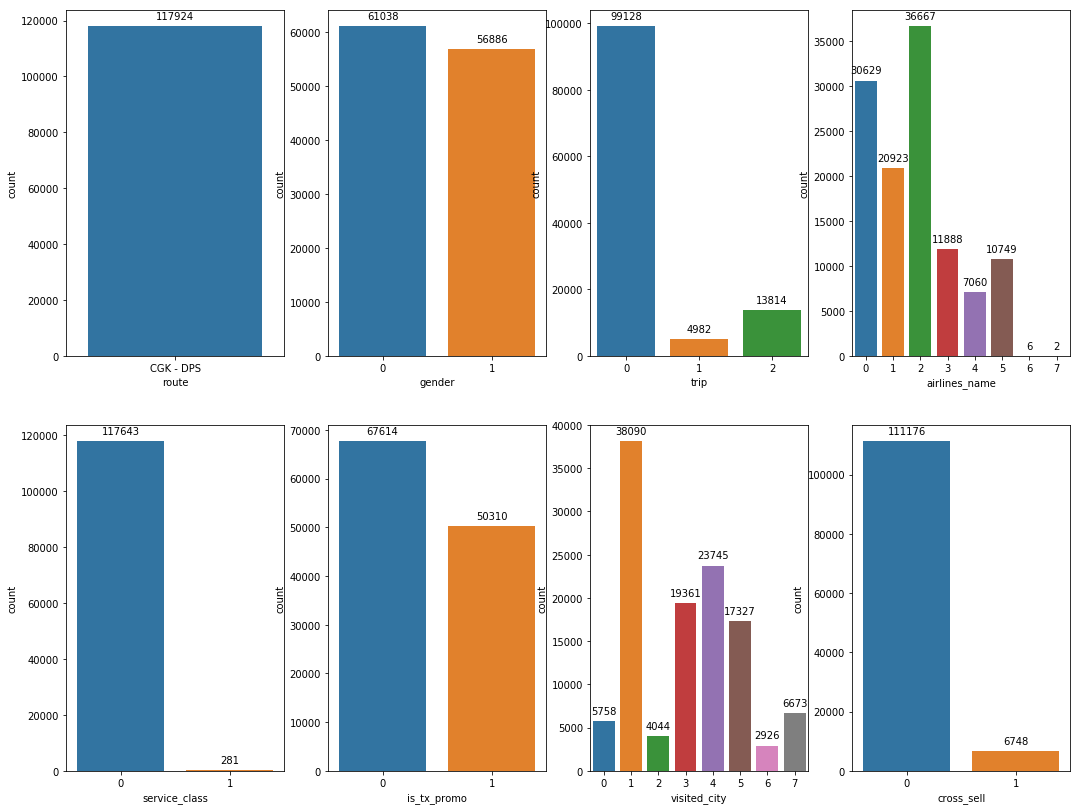

In [19]:
# Membuat subplot dan mengatur ukuran figur
fig, axes = plt.subplots(2, 4, figsize=(18, 14))

# Menggunakan fungsi yang telah dibuat untuk membuat countplot dengan mudah
count_plot_with_annotation('route', flight, 0, 0) # Countplot pada variabel route
count_plot_with_annotation('gender', flight, 0, 1) # Countplot pada variabel gender
count_plot_with_annotation('trip', flight, 0, 2) # Countplot pada variabel trip
count_plot_with_annotation('airlines_name', flight, 0, 3) # Countplot pada variabel airlines_name
count_plot_with_annotation('service_class', flight, 1, 0) # Countplot pada variabel service_class
count_plot_with_annotation('is_tx_promo', flight, 1, 1) # Countplot pada variabel is_tx_promo  
count_plot_with_annotation('visited_city', flight, 1, 2) # Countplot pada variabel visited_city
count_plot_with_annotation('cross_sell', flight, 1, 3) # Countplot pada variabel cross_sell

**Hasil analisa dari grafik diatas adalah sebagai berikut**
***
Keterangan numerik (0, 1, 2, ...) dapat dilihat pada [bagian ini](#keterangan).
1. Feature 'route' hanya memiliki satu value yaitu CGK-DPS, sehingga tidak akan berguna dalam model prediksi.
2. Feature 'gender' yang telah dibersihkan dari missing value memiliki jumlah yang kurang lebih seimbang.
3. Feature 'service_class' sangat tidak seimbang dimana tiket ekonomi jauh lebih banyak dibandingkan tiket business, sehingga feature ini tidak digunakan dalam model prediksi.
4. Feature cross_sell tidak balanced, karena feature ini merupakan feature target maka akan dilakukan metode sampling dengan library imblearn dan metode SMOTE. 


### 3.1.2 Probabilitas terjadi cross sell berdasarkan feature yang ada
<a id="3.1.2"></a>
***

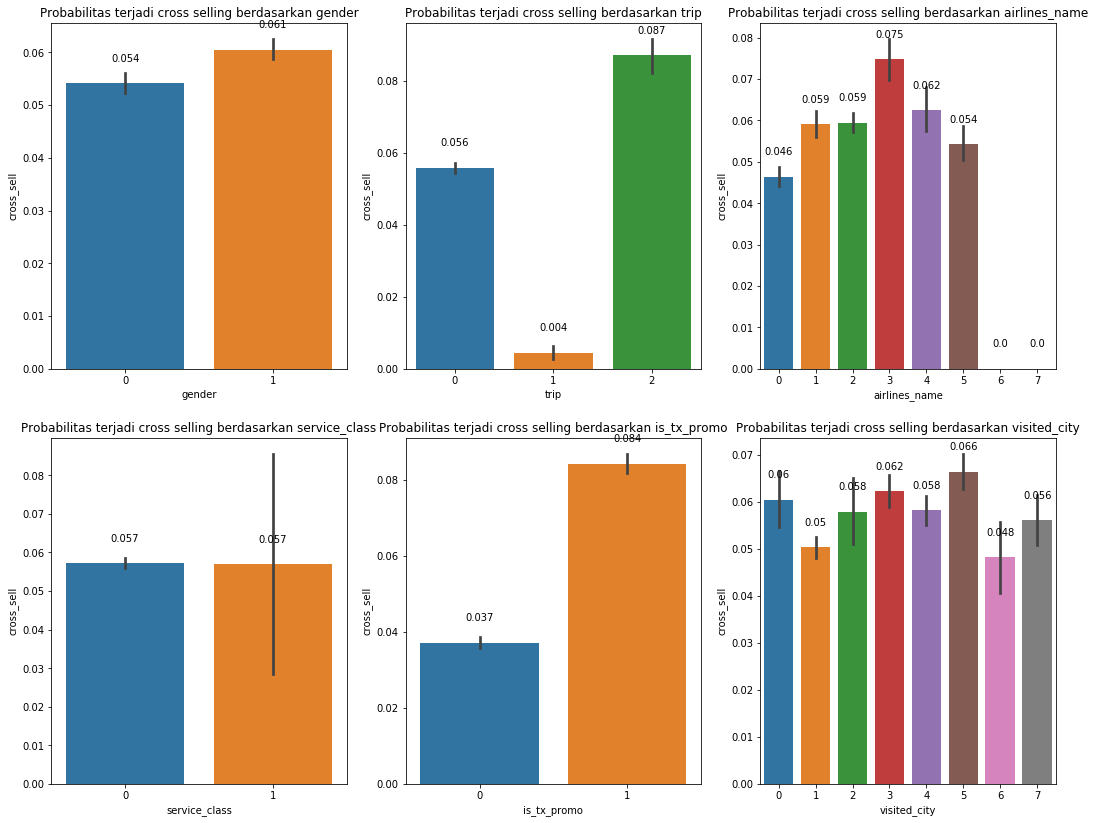

In [20]:
# Membuat subplot dan mengatur ukuran figur
fig, axes = plt.subplots(2, 3, figsize=(18, 14))

# Menggunakan fungsi yang telah dibuat untuk membuat boxplot dengan mudah
prob_box_plot_with_annotation(flight['gender'], flight['cross_sell'], 0, 0)
prob_box_plot_with_annotation(flight['trip'], flight['cross_sell'], 0, 1)
prob_box_plot_with_annotation(flight['airlines_name'], flight['cross_sell'], 0, 2)
prob_box_plot_with_annotation(flight['service_class'], flight['cross_sell'], 1, 0)
prob_box_plot_with_annotation(flight['is_tx_promo'], flight['cross_sell'], 1, 1)
prob_box_plot_with_annotation(flight['visited_city'], flight['cross_sell'], 1, 2)

**Hasil analisa dari grafik diatas adalah sebagai berikut**
***
Keterangan numerik (0, 1, 2, ...) dapat dilihat pada [bagian ini](#keterangan).
1. Probabilitas terjadi cross selling pada masing-masing value tergolong sangat kecil. Dugaan kami hal ini dikarenakan kecilnya korelasi feature-feature diatas terhadap feature target, cross_sell.
2. Pada feature airlines_name, 6 dan 7 memiliki nilai probabilitas 0, sehingga kemungkinan tidak akan digunakan dalam model prediksi.

### 3.1.3 Factorplot antar feature
<a id="3.1.3"></a>
***

**Gender vs Trip**
<a id="3.1.3.1"></a>

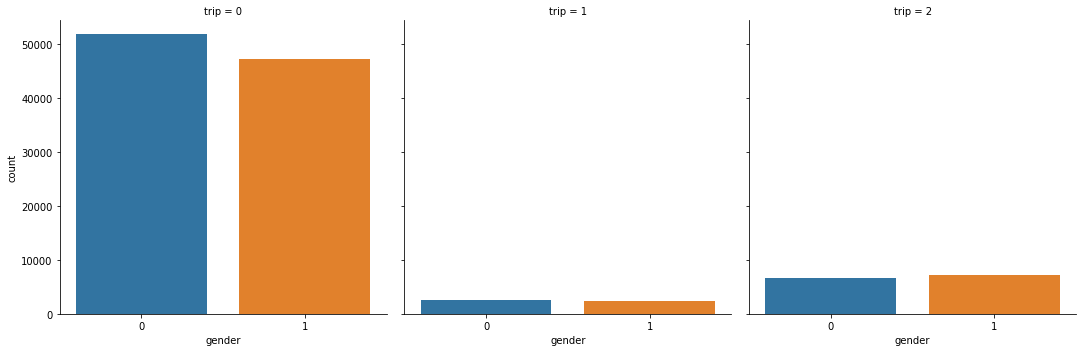

In [21]:
sns.factorplot('gender', col = 'trip', data = flight, kind = 'count')

**Hasil analisa dari grafik diatas adalah sebagai berikut**
***
Keterangan numerik (0, 1, 2, ...) dapat dilihat pada [bagian ini](#keterangan).
1. Data yang dimiliki terbanyak adalah order/pembelian oleh pria. 
2. Pria memiliki pembelian terbanyak pada tiket 'trip' dan 'round', sedangkan pada tiket 'roundtrip' pembelian terbanyak dilakukan oleh perempuan.

**Gender vs Airlines_name**
<a id="3.1.3.2"></a>

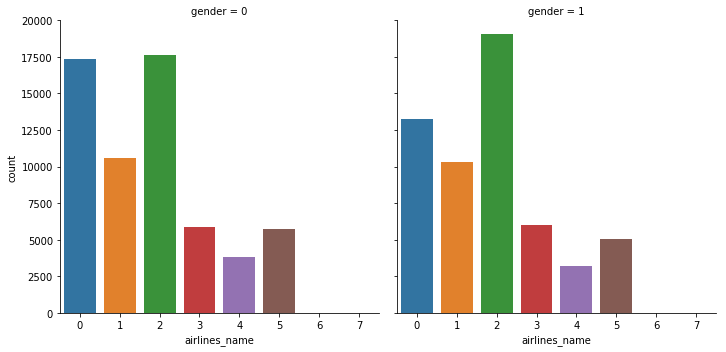

In [22]:
sns.factorplot('airlines_name', col = 'gender', data = flight, kind = 'count')

**Hasil analisa dari grafik diatas adalah sebagai berikut**
***
Keterangan numerik (0, 1, 2, ...) dapat dilihat pada [bagian ini](#keterangan).
1. Uniknya, keputusan pemilihan maskapai penerbangan antara pria dan perempuan sangat seimbang. Hipotesis kami pada kasus ini adalah jenis kelamin tidak terlalu berpengaruh terhadap penentuan maskapai penerbangan, penentuan maskapai penerbangan lebih condong kepada tingkat ekonomi pelanggan, pengalaman kenyamanan yang dirasakan pada masing-masing maskapai, dan tujuan penerbangan.

**Gender vs Service_class**
<a id="3.1.3.3"></a>

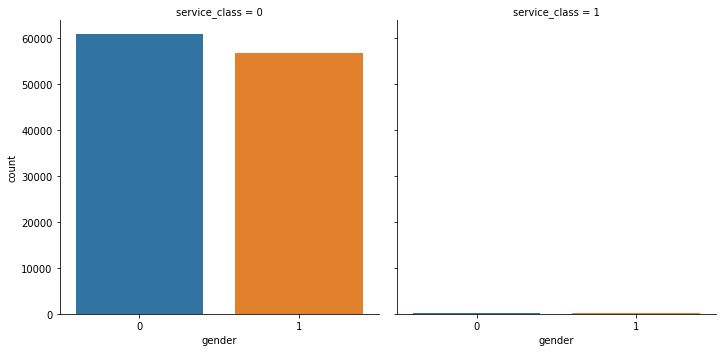

In [23]:
sns.factorplot('gender', col = 'service_class', data = flight, kind = 'count')

**Gender vs is_tx_promo**
<a id="3.1.3.4"></a>

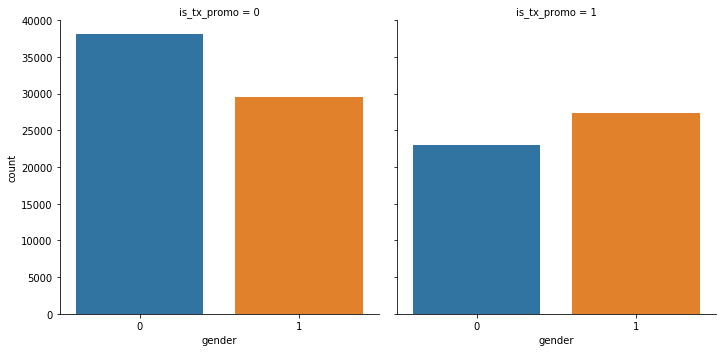

In [24]:
sns.factorplot('gender', col = 'is_tx_promo', data = flight, kind = 'count')

**Hasil analisa dari grafik diatas adalah sebagai berikut**
***
Keterangan numerik (0, 1, 2, ...) dapat dilihat pada [bagian ini](#keterangan).
1. Dibandingkan pria, perempuan memiliki transaksi lebih banyak menggunakan promo.

**Gender vs visited_city**
<a id="3.1.3.5"></a>

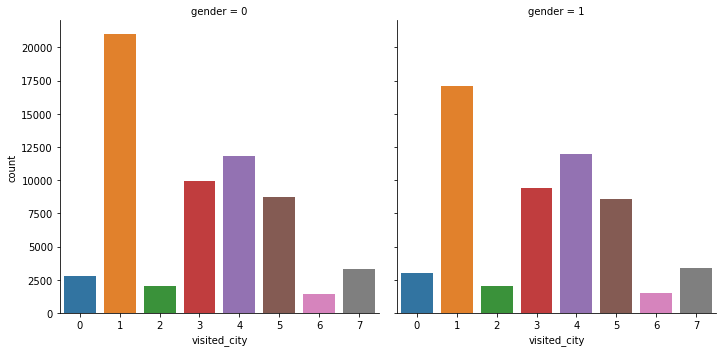

In [25]:
sns.factorplot('visited_city', col = 'gender', data = flight, kind = 'count')

**Hasil analisa dari grafik diatas adalah sebagai berikut**
***
Keterangan numerik (0, 1, 2, ...) dapat dilihat pada [bagian ini](#keterangan).
1. Kota yang dikunjungi antara pria maupun perempuan kurang lebih memiliki frekuensi yang sama.

**Trip vs Airlines_name**
<a id="3.1.3.6"></a>

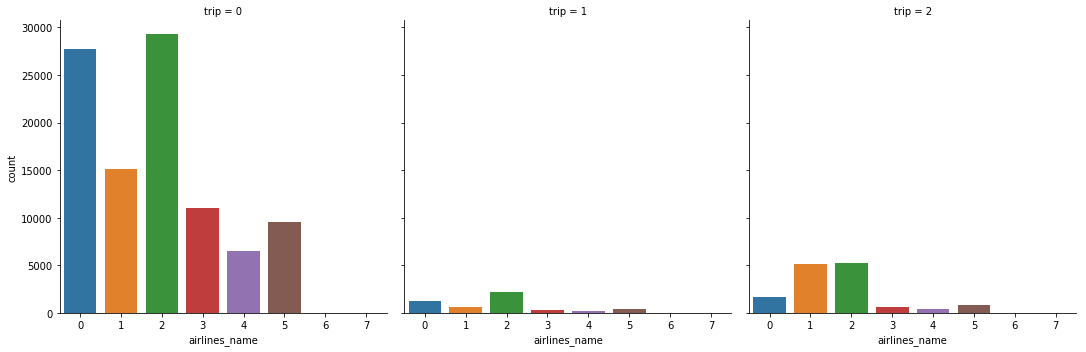

In [26]:
sns.factorplot('airlines_name', col = 'trip', data = flight, kind = 'count')

**Trip vs Service_class**
<a id="3.1.3.7"></a>

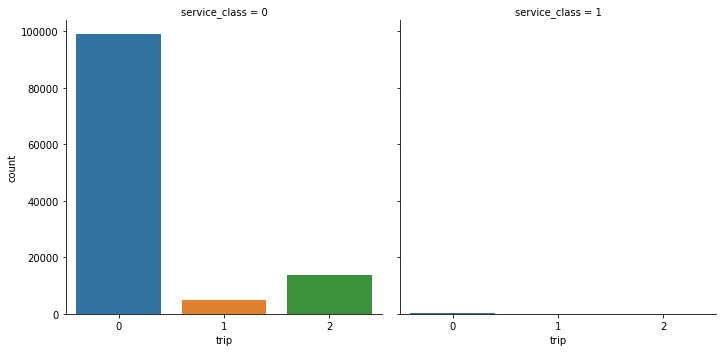

In [27]:
sns.factorplot('trip', col = 'service_class', data = flight, kind = 'count')

**Trip vs is_tx_promo**
<a id="3.1.3.8"></a>

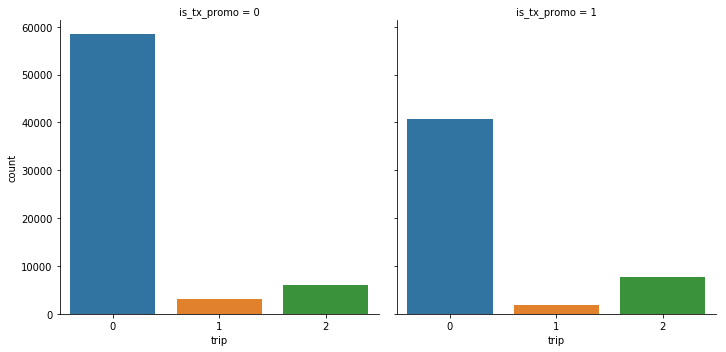

In [28]:
sns.factorplot('trip', col = 'is_tx_promo', data = flight, kind = 'count')

**Hasil analisa dari grafik diatas adalah sebagai berikut**
***
Keterangan numerik (0, 1, 2, ...) dapat dilihat pada [bagian ini](#keterangan).
1. Promo tidak mempengaruhi penentuan tipe dari trip, terlihat dari grafik diatas bahwa frekuensinya kurang lebih sama antar tipe trip.

**Trip vs visited_city**
<a id="3.1.3.9"></a>

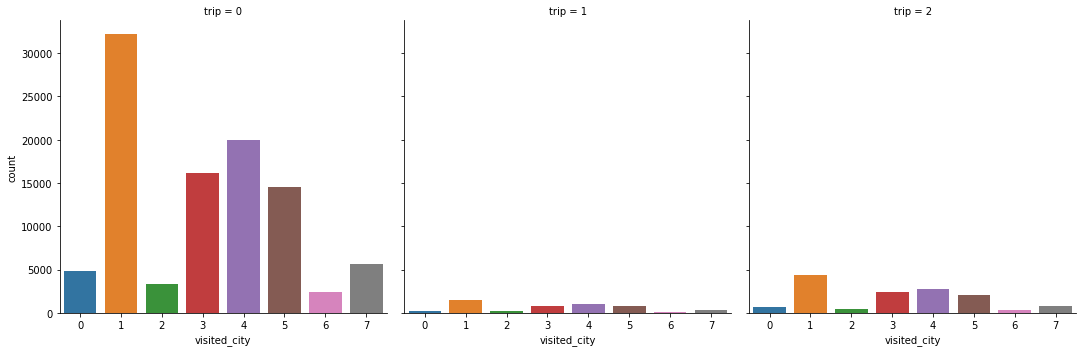

In [29]:
sns.factorplot('visited_city', col = 'trip', data = flight, kind = 'count')

**Airlines_name vs Service_class**
<a id="3.1.3.10"></a>

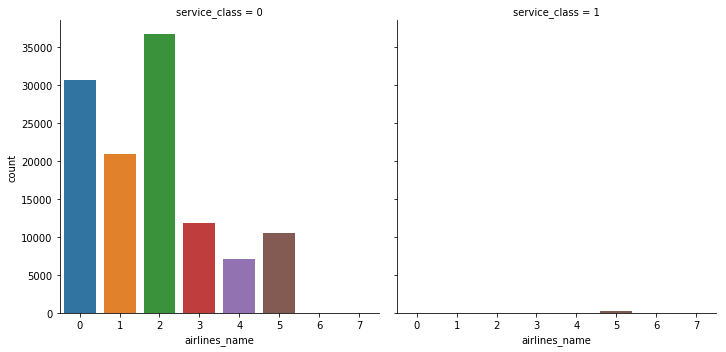

In [30]:
sns.factorplot('airlines_name', col = 'service_class', data = flight, kind = 'count')

**Airlines_name vs is_tx_promo**
<a id="3.1.3.11"></a>

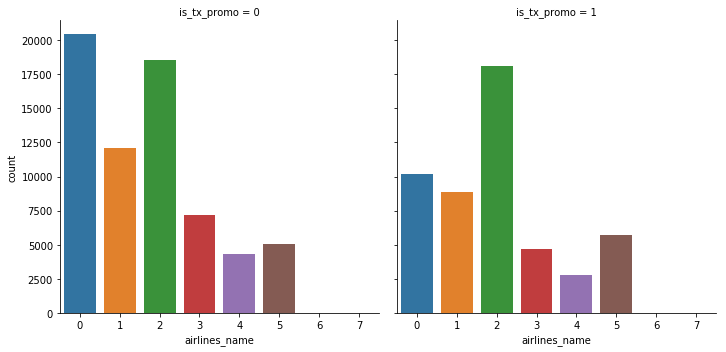

In [31]:
sns.factorplot('airlines_name', col = 'is_tx_promo', data = flight, kind = 'count')

**Hasil analisa dari grafik diatas adalah sebagai berikut**
***
Keterangan numerik (0, 1, 2, ...) dapat dilihat pada [bagian ini](#keterangan).
1. Maskapai penerbangan '33199710eb822fbcfd0dc793f4788d30' lebih dipilih ketika tidak menggunakan promo, tetapi ketika menggunakan promo, pelanggan cenderung lebih menggunakan maskapai '6c483c0812c96f8ec43bb0ff76eaf716'

**Airlines_name vs visited_city**
<a id="3.1.3.12"></a>

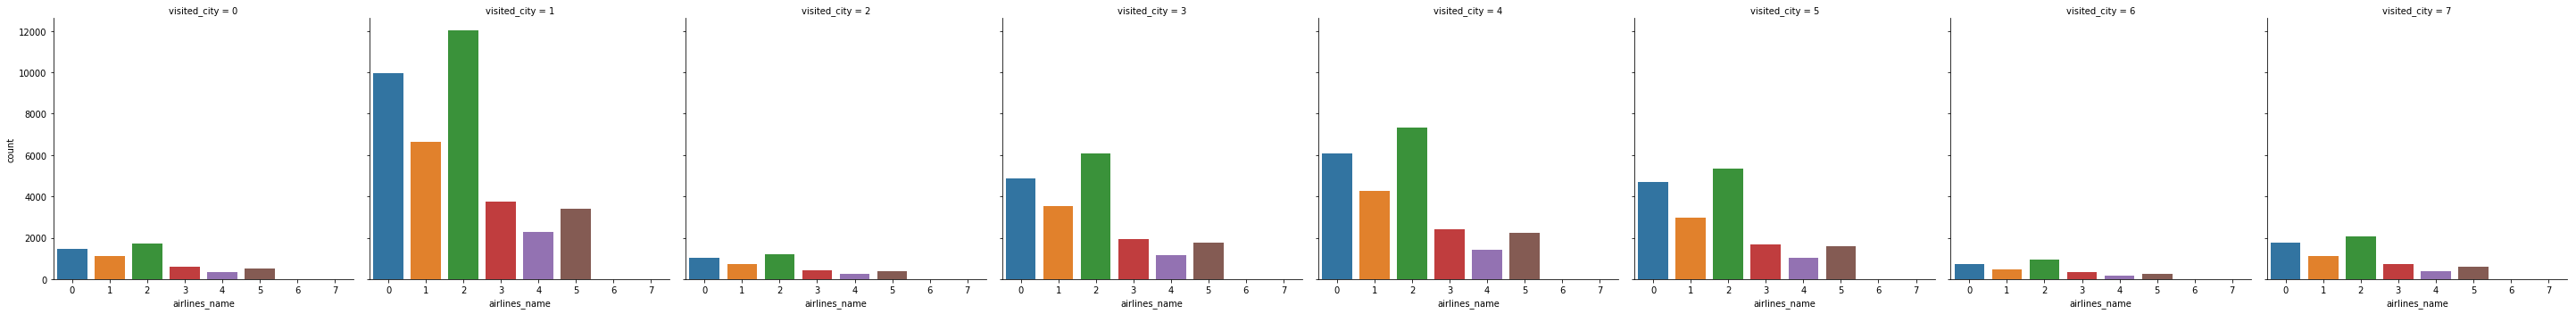

In [32]:
sns.factorplot('airlines_name', col = 'visited_city', data = flight, kind = 'count')

**Service_class vs is_tx_promo**
<a id="3.1.3.13"></a>

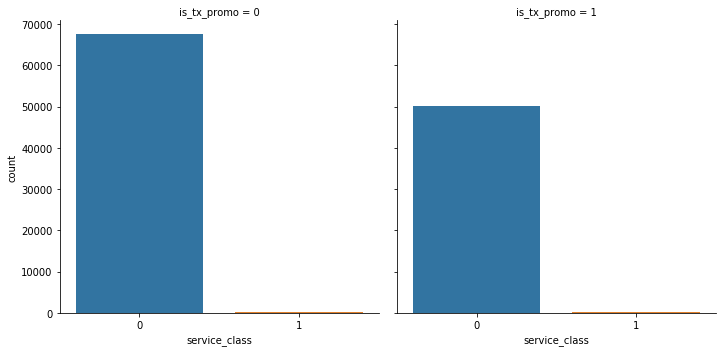

In [33]:
sns.factorplot('service_class', col = 'is_tx_promo', data = flight, kind = 'count')

**Service_class vs visited_city**
<a id="3.1.3.14"></a>

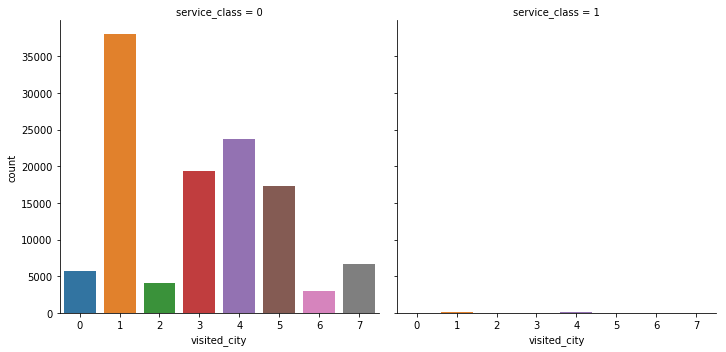

In [34]:
sns.factorplot('visited_city', col = 'service_class', data = flight, kind = 'count')

**is_tx_promo vs visited_city**
<a id="3.1.3.15"></a>

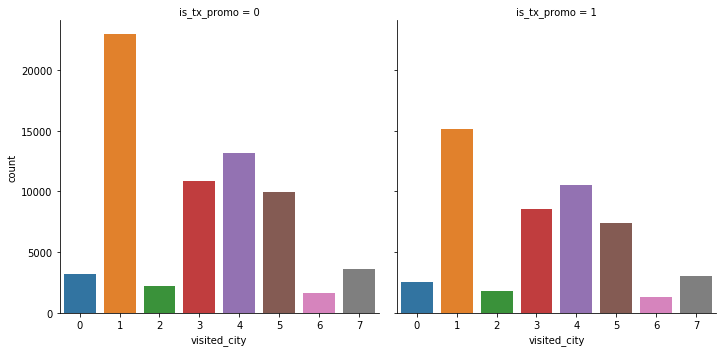

In [35]:
sns.factorplot('visited_city', col = 'is_tx_promo', data = flight, kind = 'count')

**Hasil analisa dari grafik diatas adalah sebagai berikut**
***
Keterangan numerik (0, 1, 2, ...) dapat dilihat pada [bagian ini](#keterangan).
1. Kota yang telah dikungjungi oleh pelanggan tidak dipengaruhi oleh ada atau tidak adanya promo.

### 3.1.4 Feature route
<a id="3.1.4"></a>
***
Terlihat pada grafik sub-bab 3.1.1 bahwa route hanya memiliki 1 value yaitu CGK - DPS, sehingga tidak akan digunakan pada tahapan-tahapan selanjutnya

## 3.2 Eksplorasi Feature Numerik
<a id="numeric"></a>
***


### 3.2.1 Distribusi antar feature
<a id="3.2.1"></a>
***

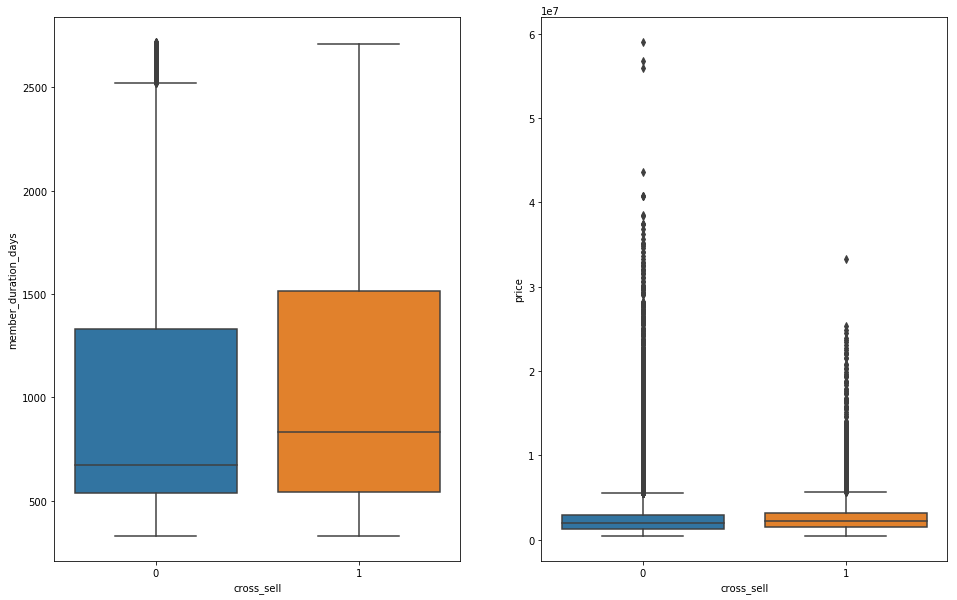

In [36]:
figbi, axesbi = plt.subplots(1, 2, figsize=(16, 10))
sns.boxplot(x="cross_sell", y="member_duration_days", data=flight,ax=axesbi[0])
sns.boxplot(x="cross_sell", y="price", data=flight,ax=axesbi[1])

**Feature no_of_seats**

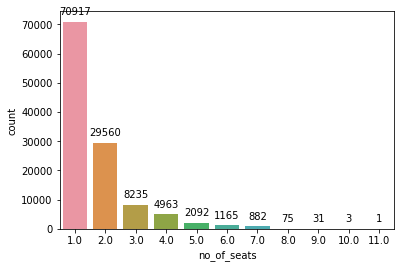

In [37]:
ax = sns.countplot(x = 'no_of_seats',data = flight) # Countplot pada variabel no_of_seats

for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')


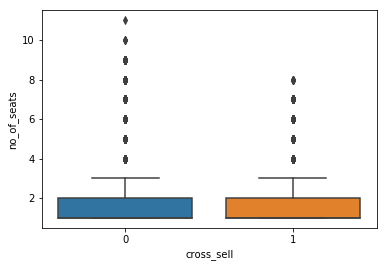

In [38]:
sns.boxplot(x="cross_sell", y="no_of_seats", data=flight)

**Hasil analisa dari grafik diatas adalah sebagai berikut**
***
1. Dataset flight memiliki sangat banyak nilai ekstrim, terutama pada feature price dan no_of_seats. Hal ini dikarenakan feature price merupakan total pembayaran harga tiket berdasarkan jumlah tiket yang dibeli. Pembelian 10 seats secara langsung membuat price menjadi puluhan juta sedangkan pembelian 1 seats memiliki kisaran harga ratusan ribu hingga jutaan.

Solusi dari permasalahan diatas dapat diatasi pada tahap feature engineering dengan menambahkan feature rata-rata harga tiket dengan formula price_avg = price/no_of_seats

### 3.2.2 Scatterplot antar feature
<a id="3.2.2"></a>
***

**price vs member_duration_days**

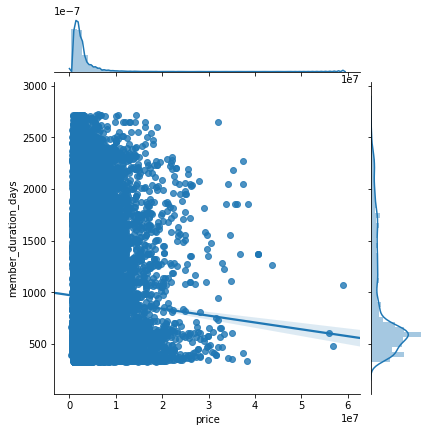

In [39]:
sns.jointplot("price", "member_duration_days", data=flight, kind="reg")

**price vs no_of_seats**

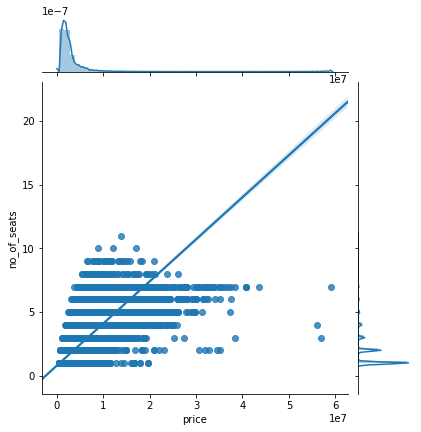

In [40]:
sns.jointplot("price", "no_of_seats", data=flight, kind="reg")

**member_duration_days vs no_of_seats**

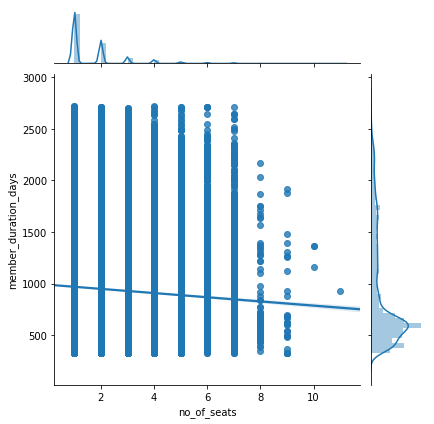

In [41]:
sns.jointplot("no_of_seats", "member_duration_days", data=flight, kind="reg")

**Hasil analisa dari grafik diatas adalah sebagai berikut**
***
Dengan membuat scatterplot seperti grafik diatas, data outlier lebih terlihat. Distribusi dari setiap feature numerik juga bukan normal distribution melainkan high skewed distribution. Untuk mengurangi dampak dari permasalahan ini, data akan dilakukan normalisasi. Kelompok kami tidak menghapus data outlier tersebut karena melihat distribusi pada data test juga memiliki outlier dan memiliki distribusi high skewed.

## 3.3 Kesimpulan Hasil Eksplorasi
<a id="3.3"></a>
***
Kesimpulan penting yang dapat ditarik dari hasil eksplorasi diatas adalah
1. Terdapat feature yang tidak terlalu berguna untuk dijadikan input model prediksi, yaitu feature route dan service_class.
2. Terdapat sangat banyak outlier pada dataset flight maupun testing. Solusi yang dapat dilakukan adalah dengan melakukan normalisasi. Kelompok kami tidak melakukan penghapusan outlier tersebut karena pada data test juga terdapat banyak outlier.
3. Terdapat beberapa feature baru yang dapat dibuat pada tahap selanjutnya (feature engineering), yaitu <br>
    * Account pelanggan, hal ini dikarenakan terdapat banyak order yang dilakukan oleh 1 pelanggan dan account pelanggan tidaklah unique pada setiap baris.
    * Feature yang menunjukan apakah pelanggan pernah melakukan cross_selling.
    * Estimasi jumlah cross selling yang dilakukan oleh pelanggan selama 2018.
    * Harga tiket/seat
    * Harga tiket dalam jutaan

# 4. Feature Engineering
<a id="4"></a>
***
Beberapa langkah yang dilakukan pada tahap ini adalah berusaha mempersiapkan feature untuk dijadikan input model prediksi. Hal-hal yang dilakukan pada tahap ini, yaitu membuat feature baru, memilih feature yang akan digunakan, dll

## 4.1 Membuat Feature Baru
<a id="4.1"></a>
***
Berdasarkan hasil eksplorasi pada tahap-tahap sebelumnya maka beberapa feature dapat ditambahkan seperti dibawah ini. Adapun penambahan beberapa feature juga telah dilakukan pada sub-bab 2.2 untuk mengefisiensikan baris kode.

### 4.1.1 Feature Baru dari member_duration_days
<a id="4.1.1"></a>
***

In [42]:
# Mengubah bentuk dari member_duration_days kedalam bentuk tahunan (menggunakan standar 1 tahun = 365 hari)
flight['member_duration_years'] = flight['member_duration_days'] // 365 
df_test['member_duration_years'] = df_test['member_duration_days'] // 365

# Mengubah bentuk dari member_duration_days kedalam bentuk bulanan (menggunakan standar 1 tahun = 12 bulan)
flight['member_duration_months'] = (flight['member_duration_days'] % 365) // 12
df_test['member_duration_months'] = (df_test['member_duration_days'] % 365) // 12

# Menambahkan feature sisa hari, contohnya 1 tahun, 4 bulan, 20 hari. 20 hari tersebut menjadi nilai pada feature ini.
flight['member_duration_days_left'] = (flight['member_duration_days'] % 365) % 12
df_test['member_duration_days_left'] = (df_test['member_duration_days'] % 365) % 12

### 4.1.2 Feature Baru dari price
<a id="4.1.2"></a>
***

In [43]:
# Mengubah bentuk price kedalam jutaan
flight['price_in_million'] = flight['price'] // 1000000 
df_test['price_in_million'] = df_test['price'] // 1000000

# Mendapatkan nilai price per jumlah seat yang dibeli
flight['price_avg'] = flight['price'] / flight['no_of_seats']
df_test['price_avg'] = df_test['price'] / df_test['no_of_seats']

### 4.1.3 Feature Baru dari no_of_seats
<a id="4.1.3"></a>
***

In [44]:
# Code dibawah ini membuat feature baru, apakah pelanggan tersebut naik pesawat secara individu atau berkelompok. 
# Dibuktikan dengan nilai no_of_seats
is_alone = []

for i in flight["no_of_seats"]:
    if i > 1:
        is_alone.append(0)
    else:
        is_alone.append(1)

flight["is_alone"] = pd.Series(np.array(is_alone))

is_alone = []

for i in df_test["no_of_seats"]:
    if i > 1:
        is_alone.append(0)
    else:
        is_alone.append(1)

df_test["is_alone"] = pd.Series(np.array(is_alone))

### 4.1.4 Feature Baru dari account_id dan cross_sell
<a id="4.1.4"></a>
***

In [45]:
# Fungsi untuk mendapatkan index dari list 2 dimensi
def index_2d(myList, v):
    for i, x in enumerate(myList):
        if v in x:
            return i

In [46]:
# Code dibawah ini untuk melabeli pelanggan menggunakan numerik.
# acc_index = 74791 digunakan untuk data test karena nilai maskimal pada data flight adalah 74791.
# Adapun terdapat akun yang sama pada data test dan data flight sehingga dapat meningkatkan keakuratan hasil prediksi.

# flight['account'] = pd.factorize(flight.account_id)[0]
# acc_index = 74791
# account = []
# for i in range(0, len(df_test.account_id)):
#     val1 = df_test.account_id[i]
#     index = index_2d(flight.account_id, val1)
#     if index == None:
#         acc_index += 1
#         account.append(acc_index)
#     else:
#         account.append(flight.account[index])

# df_test['account'] = pd.Series(np.array(account))


# Code dibawah ini untuk membuat feature apakah pelanggan tersebut pernah melakukan cross selling sekaligus 
# mendapatkan berapa kali melakukan cross_selling dalam 2018.
# have_cross = []
# n_cross = []
# for i in range(0, len(flight.account_id)):
#     account = flight.account[i]
#     if len(flight[flight.account == account][flight.cross_sell == 1]) == 0:
#         have_cross.append(0)
#         n_cross.append(0)
#     else:
#         have_cross.append(1)
#         n_cross.append(len(flight[flight.account == account][flight.cross_sell == 1]))
               
# flight['have_cross'] = pd.Series(np.array(have_cross))
# flight['n_cross'] = pd.Series(np.array(n_cross))

# have_cross = []
# for i in range(0, len(df_test.account_id)):
#     account = df_test.account[i]
#     if len(flight[flight.account == account][flight.cross_sell == 1]) == 0:
#         have_cross.append(0)
#         n_cross.append(0)
#     else:
#         have_cross.append(1)
#         n_cross.append(len(flight[flight.account == account][flight.cross_sell == 1]))
                
# df_test['have_cross'] = pd.Series(np.array(have_cross))
# df_test['n_cross'] = pd.Series(np.array(n_cross))

## 4.2 Menghapus Feature Yang Tidak Berguna
<a id="4.2"></a>
***

In [47]:
# Code dibawah ini digunakan untuk menghapus feature yang tidak berguna berdasarkan hasil analisa pada tahap sebelumnya

# flight = flight.drop(['order_id', 'account_id', 'route', 'log_transaction'], axis=1)

# Menyimpan order_id dari data test (digunakan untuk submission)
# df_test_order_id = df_test.order_id
# df_test = df_test.drop(['order_id', 'account_id', 'route', 'log_transaction'], axis=1)

## 4.3 Mengubah Variabel Kategorikal Menjadi Dummy
<a id="4.3"></a>
***

In [48]:
# Code dibawah ini digunakan untuk mengubah categorical menjadi dummy/indikator.

# cat_features = ['trip', 'airlines_name', 'visited_city']

# for feature in cat_features:
#     a = pd.get_dummies(flight[feature], prefix = feature)
#     frames = [flight, a]
#     flight = pd.concat(frames, axis = 1)
    
#     b = pd.get_dummies(df_test[feature], prefix = feature)
#     frames = [df_test, b]
#     df_test = pd.concat(frames, axis = 1)
    
# flight.drop(cat_features, axis = 1, inplace=True)
# df_test.drop(cat_features, axis = 1, inplace=True)
# flight

Dataframe diatas merupakan data yang telah diproses namun belum dilakukan normalisasi.

**Korelasi antar feature**
***
Terlihat bahwa feature yang dibuat pada saat feature engineering memiliki korelasi yang tinggi pada feature target

In [49]:
# flight.corr()["cross_sell"].sort_values(ascending = False)

**Export dataset yang telah dibersihkan**
***
Hal ini dilakukan untuk mempermudah pekerjaan, tanpa perlu menjalankan baris code yang telah dilakukan berkali-kali.

In [50]:
# flight.to_csv('cleaned_flight.csv', index=False)
# df_test.to_csv('cleaned_df_test.csv', index=False)

**Import dataset yang telah bersih**
***

In [51]:
# flight = pd.read_csv('cleaned_flight.csv')
# df_test = pd.read_csv('cleaned_df_test.csv')

## 4.4 Pemilihan Feature
<a id="4.4"></a>
***
Pemilihan feature berikut didasarkan pada korelasi dengan target

In [52]:
# Berikut adalah feature yang dipilih berdasarkan korelasi
# columns = ['account', 'member_duration_days', 'member_duration_years',
#        'total_transaksi', 'have_spend_10m', 'have_spend_100m', 'no_of_seats',
#        'price', 'price_avg', 'have_visit_srg', 'have_cross',
#        'n_cross', 'have_visit_jogc', 'have_visit_sby', 'have_visit_mdc',
#        'gender', 'trip_0', 'is_alone', 'trip_1', 'trip_2', 'is_tx_promo',
#        'airlines_name_1', 'airlines_name_2',
#        'airlines_name_3', 'airlines_name_4', 'airlines_name_5',
#        'visited_city_0', 'visited_city_1', 'visited_city_2', 'visited_city_3',
#        'visited_city_4', 'visited_city_5', 'visited_city_7', 'cross_sell']

# flight = flight[columns]
# del columns[-1]
# df_test = df_test[columns]

# 5. Modelling dan Validasi
<a id="5"></a>
***
Pada tahap ini dilakukan modelling terhadap data yang telah dibersihkan pada tahap sebelumnya.

## 5.1 Sampling, Normalisasi dan Split Data
<a id="5.1"></a>
***
Dikarenakan dataset yang dimiliki mempunyai kelas/target yang tidak balanced maka akan dilakukan metode sampling.
Metode sampling ini menggunakan library imblearn dengan metode SMOTE (Synthetic Minority Over-sampling Technique) minority.

Alasan tim kami memilih metode tersebut adalah
1. SMOTE minority merupakan metode oversampling, dimana data dengan kelas minoritas (dalam hal ini terjadi cross_selling) dilakukan penggandaan sehingga seimbang dengan kelas mayoritas.
2. Mempertimbangkan k-NN terdekat dari kelas minoritas, lalu membangun vektor ruang antar k.
3. Oversampling dilakukan karena kami tidak ingin kehilangan banyak data jika menggunakan metode undersampling.

In [53]:
# Membuat variabel train dan variabel target(cross_sell)
# train = flight.drop("cross_sell", axis=1)
# target = flight["cross_sell"]

# Melakukan metode oversampling untuk mengatasi imbalanced data
# smote = SMOTE(sampling_strategy='minority')
# train, target = smote.fit_sample(train, target)

# Melakukan normalisasi pada data, hal ini dilakukan karena terdapat banyak data yang memiliki nilai tidak seimbang
# seperti nilai price terhadap member_duration_days, dan juga kami berharap masalah outlier dapat teratasi dengan normalisasi
# scaler = StandardScaler()
# train = scaler.fit_transform(train)
# scaled_df_test = scaler.fit_transform(df_test)

# melakukan pembagian data menjadi data latih (80%) dan data validasi (20%)
# X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state = 123)

Berikut merupakan shape/ukuran dari X_train, X_test, y_train, dan y_test.

In [54]:
# print('Ukuran X_train = ', X_train.shape, 
#       '\nUkuran X_test  = ', X_test.shape, 
#       '\nUkuran y_train = ', y_train.shape,
#       '\nUkuran y_test  = ', y_test.shape
#      )

Berikut merupakan tampilan dari X_train yang merupakan dataset yang telah dibersihkan, di normalisasi, dan disampling menggunakan metode SMOTE.

In [55]:
# pd.DataFrame(X_train)

## 5.2 Modelling-Validasi Dengan Berbagai Metode
<a id="5.2"></a>
***

In [56]:
# Code dibawah ini melakukan pelatihan pada data training dan validasi pada data test hasil split data flight
# Metode yang digunakan pada tahapan ini adalah xgboost, knn, random forest, decision tree, dan gradient boosting.
# parameter awal yang digunakan adalah parameter default

# xgboost_model = XGBClassifier()
# knn_model = KNeighborsClassifier() 
# rfc_model = RandomForestClassifier()
# dtc_model = DecisionTreeClassifier()
# gbc_model = GradientBoostingClassifier()

# model_score = []
# all_model = [xgboost_model, knn_model, rfc_model, dtc_model, gbc_model]
# for model in all_model:
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     f_score = f1_score(y_test, y_pred, average='macro')
#     accuracy = accuracy_score(y_test, y_pred)
#     model_score.append([model.__class__.__name__, f_score, accuracy])
#     print("Metode {}".format(model.__class__.__name__))
#     print('Score F1-Macro = ', f_score, ', Accuracy = ', accuracy)
#     tn, fp, fn, tp = confusion_matrix(y_true=y_test, y_pred=y_pred).ravel()
#     print('TN:', tn, '\nFP:',fp, '\nFN:', fn, '\nTP:', tp)
#     print('\n')

In [57]:
# df_score = pd.DataFrame(model_score)
# df_score.columns = ['metode', 'f1-score', 'akurasi']
# df_score

Berdasarkan hasil diatas, metode random forest merupakan metode terbaik dengan nilai f1-score dan akurasi sebesar 0.989.

## 5.3 Parameter Tunning
<a id="5.3"></a>
***
RandomizedSearchCV dipilih untuk mengoptimasi parameter karena lebih cepat dibandingkan dengan metode GridSearchCV.

### 5.3.1 Parameter Tunning pada XGBoost
<a id="5.3.1"></a>
***

In [58]:
# param_grid = {'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
#               'n_estimators': [25, 50, 75, 100, 125, 150, 200],
#               'max_depth' : [25, 50, 75, 100, 125, 150, 200]
#              }
# grid = RandomizedSearchCV(XGBClassifier(), param_grid,
#                           cv=5, verbose=1, scoring='f1_macro', n_jobs = -1)

# grid.fit(X_train, y_train)
# grid.best_params_

### 5.3.2 Parameter Tunning pada k-NN
<a id="5.3.2"></a>
***

In [59]:
# param_grid = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
# grid = RandomizedSearchCV(KNeighborsClassifier(), param_grid,
#                           cv=5, verbose=1, scoring='f1_macro', n_jobs = -1)

# grid.fit(X_train, y_train)
# grid.best_params_

### 5.3.3 Parameter Tunning pada Random Forest
<a id="5.3.3"></a>
***

In [60]:
# param_grid = {
#               'n_estimators': [25, 50, 75, 100, 125, 150, 200],
#               'max_depth' : [5, 10, 25, 50, 75, 100, 125, 150, 200]
#              }
# grid = RandomizedSearchCV(RandomForestClassifier(), param_grid,
#                           cv=5, verbose=1, scoring='f1_macro', n_jobs = -1)

# grid.fit(X_train, y_train)
# grid.best_params_

### 5.3.4 Parameter Tunning pada Decision Tree
<a id="5.3.4"></a>
***

In [61]:
# param_grid = {
#               'max_depth' : [5, 10, 25, 50, 75, 100, 125, 150, 200]
#              }
# grid = RandomizedSearchCV(DecisionTreeClassifier(), param_grid,
#                           cv=5, verbose=1, scoring='f1_macro', n_jobs = -1)

# grid.fit(X_train, y_train)
# grid.best_params_

### 5.3.5 Parameter Tunning pada Gradient Boosting
<a id="5.3.5"></a>
***

In [62]:
# param_grid = {'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
#               'n_estimators': [25, 50, 75, 100, 125, 150, 200],
#               'max_depth' : [25, 50, 75, 100, 125, 150, 200]
#              }
# grid = RandomizedSearchCV(GradientBoostingClassifier(), param_grid,
#                           cv=5, verbose=1, scoring='f1_macro', n_jobs = -1)

# grid.fit(X_train, y_train)
# grid.best_params_

Parameter optimal dari masing-masing metode adalah sebagai berikut <br>

XGBClassifier(learning_rate= 0.2, n_estimators= 150, max_depth=50, n_jobs= -1) <br>
KNeighborsClassifier(n_neighbors=2) <br>
RandomForestClassifier(random_state=0, n_estimators = 100, max_depth=50) <br>
DecisionTreeClassifier(max_depth=50) <br>
GradientBoostingClassifier(n_estimators=125, learning_rate=0.7, max_depth=50) <br>


Pada saat mengupload notebook pada kernel kaggle, tahapan parameter tuning tidak dijalankan karena terdapat masalah pada kernel kaggle yang menyebabkan lag dan sebagainya sehingga kami memutuskan untuk tidak memasukan output hasil running parameter tuning pada kaggle kernel. Namun hasil parameter diatas benar adanya merupakan output dari code diatas dengan metode pencarian parameter RandomSearchCV.

### 5.3.6 Modelling & Validasi Menggunakan Parameter Optimal
<a id="5.3.6"></a>
***

In [63]:
# Code dibawah ini melakukan pelatihan pada data training dan validasi pada data test hasil split data flight
# Metode yang digunakan pada tahapan ini adalah xgboost, knn, random forest, decision tree, dan gradient boosting.
# parameter yang digunakan adalah parameter hasil optimasi tahap sebelumnya.

# from sklearn.metrics import f1_score
# xgboost_model = XGBClassifier(learning_rate= 0.2, n_estimators= 150, max_depth=50, n_jobs= -1)
# knn_model = KNeighborsClassifier(n_neighbors=1) 
# rfc_model = RandomForestClassifier(random_state=0, n_estimators = 100, max_depth=50)
# dtc_model = DecisionTreeClassifier(max_depth=50)
# gbc_model = GradientBoostingClassifier(n_estimators=120, learning_rate=0.70, max_depth=50)

# model_score = []
# all_model = [xgboost_model, knn_model, rfc_model, dtc_model, gbc_model]
# for model in all_model:
#     print("Metode {}".format(model.__class__.__name__))
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     f_score = f1_score(y_test, y_pred, average='macro')
#     accuracy = accuracy_score(y_test, y_pred)
#     model_score.append([model.__class__.__name__, f_score, accuracy]) 
#     print('Score F1-Macro = ', f_score, ', Accuracy = ', accuracy)
#     tn, fp, fn, tp = confusion_matrix(y_true=y_test, y_pred=y_pred).ravel()
#     print('TN:', tn, '\nFP:',fp, '\nFN:', fn, '\nTP:', tp)
#     print('\n')

In [64]:
# df_score = pd.DataFrame(model_score)
# df_score.columns = ['metode', 'f1-score', 'akurasi']
# df_score

Setelah dilakukan tahapan optimasi parameter, maka metode XGBoost adalah yang terbaik.

## 5.4 Voting Classifier
<a id="5.4"></a>
***
Pada metode ini, digunakan semua metode yang telah dilakukan sebelumnya dengan menggunakan parameter hasil optimasi.

In [65]:
# clf1 = RandomForestClassifier(random_state=0, n_estimators = 100, max_depth=50)
# clf2 = XGBClassifier(learning_rate= 0.2, n_estimators= 150, max_depth=50, n_jobs= -1)
# clf3 = KNeighborsClassifier(n_neighbors=1) 
# clf4 = DecisionTreeClassifier(max_depth=50)
# clf5 = GradientBoostingClassifier(n_estimators=120, learning_rate=0.72, max_depth=50)
# eclf = VotingClassifier(estimators=[('rf', clf1), ('xgboost', clf2), ('knn', clf3), 
#                                     ('dt', clf3), ('gbc', clf3)], 
#                         voting='hard')
# eclf = eclf.fit(X_train, y_train)
# y_pred = eclf.predict(X_test)
# print(f1_score(y_test, y_pred, average='macro'), accuracy_score(y_test, y_pred))
# tn, fp, fn, tp = confusion_matrix(y_true=y_test, y_pred=y_pred).ravel()
# print('TN:', tn, '\n FP:',fp, '\n FN:', fn, '\n TP:', tp)

In [66]:
# Code dibawah ini digunakan untuk melihat row mana saja terjadi kesalahan prediksi
# Setelah dilakuakn analisa ini, apabila diperlukan pengerjaan dapat 
# kembali dilakukan pada tahap-tahap sebelumnya (praproses, eda, dan feature engineering) 

# for idx, prediction, label in zip(enumerate(X_test), y_pred, y_test):
#     if prediction != label:
#         print("Sample", idx, ', has been classified as', prediction, 'and should be', label) 

## 5.5 Pemilihan Model
<a id="5.5"></a>
***
Pemilihan model ini dilakukan berdasarkan perbandingan hasil score validasi pada sub-bab 5.2, 5.3 dan 5.4. Model yang terbaik adalah menggunakan k-NN dengan nilai k=1.

In [67]:
# Berikut adalah code untuk membuat file submission
# Tidak dijalankan pada kernel kaggle karena telah dilakukan pada saat code masih di local

# Y_pred = knn_model.predict(cleaned_df_test)
# prediction = []
# for pred in Y_pred:
#     if pred == 0:
#         prediction.append("no")
#     elif pred == 1:
#         prediction.append("yes")
# prediction = np.array(prediction)
# submission = pd.DataFrame({
#         "order_id": df_test_order_id,
#         "is_cross_sell": prediction
#     })
# submission.to_csv("submission.csv", index=False)

# Referensi
<a id="ref"></a>
***
[1. Medium, How to handle imbalanced data](https://medium.com/james-blogs/handling-imbalanced-data-in-classification-problems-7de598c1059f) <br>
[2. Dokumentasi Scikit-learn](https://scikit-learn.org/)<br>
[3. Dokumentasi Seaborn](https://seaborn.pydata.org/)<br>
[4. Dokumentasi Matplotlib](https://matplotlib.org/)<br>
[5. Dokumentasi XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_api.html#)<br>
[6. ANALISIS PREFERENSI KONSUMEN DALAM MENGGUNAKAN APLIKASI PENYEDIA TIKET PESAWAT & BOOKING HOTEL ONLINE oleh Agustin Wibisono dan Indrawati, Ph.D]()